# Importing & Configurations

In [47]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy
outdir = './output'

# Axion Sensitivity Expectation

In [48]:
k_B = 1.380649e-23  # boltzmann const. [J/K]
h = 4.135e-15 # eV s
c = 3e+8 # m/s

def m(nu):
    return h * nu

def dnu(nu): 
    return nu*1e-6

# Tsys: system temperature [K]
# t: measurement time [s]
# nu: frequency [Hz]
def Pdet(Tsys=100, t=1e+5, nu=1e+9):
    _dnu = dnu(nu)
    _Pdet = k_B * Tsys * np.sqrt( _dnu / t )
    return _Pdet

# nu: frequency [Hz]
# B: Maget field strength [T]
# A: Dish size [m^2]
# Tsys: system temperature [K]
# t: measurement time [s]
def g(nu=10e+9, B=10, A=0.01, Tsys=100, t=1e+5):
    _dnu = dnu(nu)
    _Pdet = Pdet(Tsys, t, nu)
    _m = m(nu)
    g = 3.6e-8 * (5/B) * np.sqrt(_Pdet / 1e-23) * _m * np.sqrt(1 / A)
    return g


def g_agg(mass, C=-1.92):
    return 2e-16 * C * mass / 1e-6
# C = E/Z - 1.92
#    = -1.92 KSVZ
#    = 0.75   DFSZ I
#    = -1.25 DFSZ II
def g_agg_KSVZ(mass): return g_agg(mass, C=1.92)
def g_agg_DFSZI(mass): return g_agg(mass, C=0.75)
def g_agg_DFSZII(mass): return g_agg(mass, C=1.25)
# C_max = E/N - 1.92 (@ E/N=44/3)
def g_agg_max(mass): return g_agg(mass, C=44/3 - 1.92)
def g_agg_max2(mass): return g_agg(mass, C=170/3 - 1.92)
def g_agg_min(mass): return g_agg(mass, C=np.abs(5/3 - 1.92))

def add_limit(
    ax, freq_list, chi_list,
    color='r',
    lcolor='r',
    alpha=0.4,
    xscale=1.,
    zorder=None, 
    ls='-', ls_side='-',
    lw=2, lw_side=None
):
    if lw_side is None: lw_side=lw
    freq_list = np.array(freq_list)
    chi_list = np.array(chi_list)
    upper_list = np.full(len(freq_list), 1.)
    mass_list = m(freq_list) * xscale
    ax.fill_between(mass_list, chi_list, upper_list, facecolor=color, edgecolor=lcolor, alpha=alpha, zorder=zorder, lw=0, ls=ls)
    ax.plot(mass_list, chi_list, color=lcolor, lw=lw, ls=ls, zorder=zorder)
    ax.plot([mass_list[0]]*2, [chi_list[0],1.], color=lcolor, lw=lw_side, ls=ls_side, zorder=zorder)
    ax.plot([mass_list[-1]]*2, [chi_list[-1],1.], color=lcolor, lw=lw_side, ls=ls_side, zorder=zorder)
    return 0

In [49]:
# 1 GHz
print(m(1e+9)*1e+6)

print( g(nu=1e+9, A=0.01, Tsys=100) )
print( g(nu=1e+9, A=0.25, Tsys=10) )

4.135
2.765601870906241e-12
1.7491202026573361e-13


In [50]:
# 10 GHz
print(m(10e+9)*1e+6)

print( g(nu=10e+9, A=0.01, Tsys=100) )
print( g(nu=10e+9, A=0.25, Tsys=10) )

41.35
4.918012863397692e-11
3.1104244420686483e-12


In [51]:
# 260 GHz
print(m(260e+9)*1e+6)

print( g(nu=260e+9, A=0.01, Tsys=100) )
print( g(nu=260e+9, A=0.25, Tsys=10) )

1075.1000000000001
2.887395965412039e-09
1.8261495514965602e-10



5.812321696117916e-11
1.8271519011925214e-10
4.3457240821777915e-10

2.906160848058958e-11
9.135759505962607e-11
2.1728620410888958e-10

1.9374405653726386e-11
6.090506337308405e-11
1.4485746940592638e-10

1.3413050067964423e-11
4.216504387367357e-11
1.0028594035794903e-10


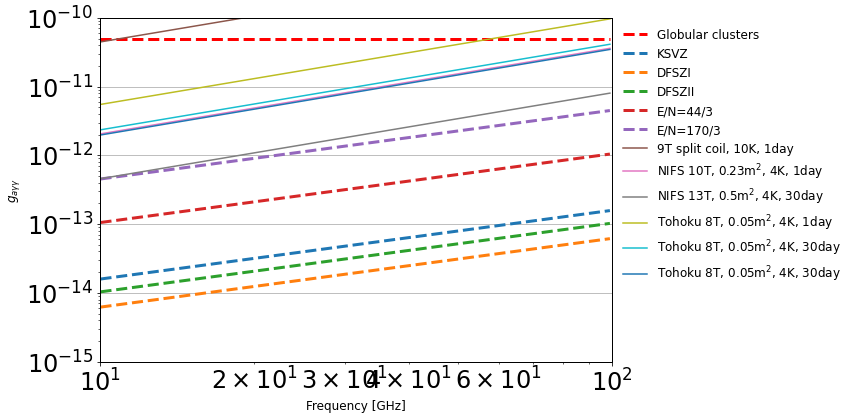

In [52]:
_freq = np.arange(10, 100, 1) * 1e+9
_freq1 = np.arange(10, 26.5, 1) * 1e+9
_freq2 = np.arange(10, 300, 1) * 1e+9

A10cm = 0.1**2
A20cm = 0.2**2
A30cm = 0.3**2
Tsys = 20

fig = plt.figure(figsize=(12, 6))
plt.plot( _freq*1e-9, np.full(len(_freq), 5e-11), c='r', ls='--', lw=3, label='Globular clusters')
plt.plot( _freq*1e-9, g_agg_KSVZ(m(_freq)), ls='--', lw=3, label='KSVZ')
plt.plot( _freq*1e-9, g_agg_DFSZI(m(_freq)), ls='--', lw=3, label='DFSZI')
plt.plot( _freq*1e-9, g_agg_DFSZII(m(_freq)), ls='--', lw=3, label='DFSZII')
plt.plot( _freq*1e-9, g_agg_max(m(_freq)), ls='--', lw=3, label='E/N=44/3')
plt.plot( _freq*1e-9, g_agg_max2(m(_freq)), ls='--', lw=3, label='E/N=170/3')

plt.plot( _freq*1e-9, g(nu=_freq, B=9, A=0.03*0.05, Tsys=10, t=1e+5), label=f'9T split coil, 10K, 1day')
'''
plt.plot( _freq*1e-9, g(nu=_freq, B=9, A=A10cm, Tsys=Tsys, t=1e+5), label=f'9T, $\phi$10cm, {Tsys}K, 1day')
plt.plot( _freq*1e-9, g(nu=_freq, B=9, A=A20cm, Tsys=Tsys, t=1e+5), label=f'9T, $\phi$20cm, {Tsys}K, 1day')
plt.plot( _freq*1e-9, g(nu=_freq, B=9, A=A30cm, Tsys=Tsys, t=1e+5), label=f'9T, $\phi$30cm, {Tsys}K, 1day')
plt.plot( _freq*1e-9, g(nu=_freq, B=13, A=A30cm, Tsys=Tsys, t=1e+5), label=f'13T, $\phi$30cm, {Tsys}K, 1day')
plt.plot( _freq*1e-9, g(nu=_freq, B=13, A=1., Tsys=Tsys, t=1e+5), label=f'13T, 1m$^2$, {Tsys}K, 1day')
plt.plot( _freq*1e-9, g(nu=_freq, B=13, A=1., Tsys=10, t=30e+5), label=f'13T, 1m$^2$, 10K, 30day')
plt.plot( _freq*1e-9, g(nu=_freq, B=13, A=1., Tsys=1, t=30e+5), label=f'13T, 1m$^2$, 1K, 30day')
plt.plot( _freq*1e-9, g(nu=_freq, B=20, A=2., Tsys=1, t=30e+5), label=f'20T, 2m$^2$, 1K, 30day')
'''
plt.plot( _freq*1e-9, g(nu=_freq, B=10, A=0.23, Tsys=4, t=1e+5), label=f'NIFS 10T, 0.23m$^2$, 4K, 1day')
plt.plot( _freq*1e-9, g(nu=_freq, B=13, A=0.5, Tsys=4, t=30e+5), label=f'NIFS 13T, 0.5m$^2$, 4K, 30day')
plt.plot( _freq*1e-9, g(nu=_freq, B=8, A=0.05, Tsys=4, t=1e+5), label=f'Tohoku 8T, 0.05m$^2$, 4K, 1day')
plt.plot( _freq*1e-9, g(nu=_freq, B=8, A=0.05, Tsys=4, t=30e+5), label=f'Tohoku 8T, 0.05m$^2$, 4K, 30day')
plt.plot( _freq*1e-9, g(nu=_freq, B=8, A=0.05, Tsys=4, t=60e+5), label=f'Tohoku 8T, 0.05m$^2$, 4K, 30day')

plt.yscale('log')
plt.xscale('log')
plt.xlim([10, 100])
plt.ylim([1e-15, 1e-10])
plt.xlabel('Frequency [GHz]')
plt.ylabel(r'$g_{a\gamma\gamma}$')
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.legend(frameon=False, loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()

print()
print( g(nu=20e+9, B=9, A=A10cm, Tsys=Tsys, t=1e+5) )
print( g(nu=50e+9, B=9, A=A10cm, Tsys=Tsys, t=1e+5) )
print( g(nu=100e+9, B=9, A=A10cm, Tsys=Tsys, t=1e+5) )
print()
print( g(nu=20e+9, B=9, A=A20cm, Tsys=Tsys, t=1e+5) )
print( g(nu=50e+9, B=9, A=A20cm, Tsys=Tsys, t=1e+5) )
print( g(nu=100e+9, B=9, A=A20cm, Tsys=Tsys, t=1e+5) )
print()
print( g(nu=20e+9, B=9, A=A30cm, Tsys=Tsys, t=1e+5) )
print( g(nu=50e+9, B=9, A=A30cm, Tsys=Tsys, t=1e+5) )
print( g(nu=100e+9, B=9, A=A30cm, Tsys=Tsys, t=1e+5) )

print()
print( g(nu=20e+9, B=13, A=A30cm, Tsys=Tsys, t=1e+5) )
print( g(nu=50e+9, B=13, A=A30cm, Tsys=Tsys, t=1e+5) )
print( g(nu=100e+9, B=13, A=A30cm, Tsys=Tsys, t=1e+5) )

# Limit: AxionLimits from 20240904
## Import AxionLimits

In [129]:
axionLimitDir='20240904_for_adachi'

In [79]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from numpy import *
import matplotlib.pyplot as plt
import os
import sys
cwd=os.getcwd()
axionLimitPath=cwd+'/../../../AxionLimits/'+axionLimitDir

# remove unnecessary path
remove_path_list = []
for _path in sys.path:
    print(_path)
    if _path.startswith(cwd+'/../../../AxionLimits'):
        remove_path_list.append(_path)
        pass
    pass
for _path in remove_path_list:
    sys.path.remove(_path)
    pass
print('path=', sys.path)

# Add axionLimitPath
if not os.path.isdir(axionLimitPath):
    print(f'ERROR!!: No directory! {axionLimitPath}')
    pass
print(axionLimitPath)
if not (axionLimitPath in sys.path):
    sys.path.append(axionLimitPath)
    pass
if os.path.islink('limit_data'):
    print('Unlink limit_data.')
    os.unlink('limit_data')
    pass
os.symlink(axionLimitPath+'/limit_data', 'limit_data')
print('path = ', sys.path)

# Import of PlotFuncs

import importlib

# 確認したいモジュール名
module_name = 'PlotFuncs' # 例としてrequestsモジュール
#  モジュールがインポートされているか確認
if module_name in sys.modules:
    print(f"モジュール '{module_name}' は既にインポートされています。")
    
    # sys.modulesからモジュールを削除
    try:
        del sys.modules[module_name]
    except Exception as e:
        print(f'Error in remove module: {module_name}')
    pass
        
# import module
import PlotFuncs
print(f'PlotFuncs path: {PlotFuncs.__file__}')

/data/analysis/adachi/analysis/Limit
/usr/lib/python38.zip
/usr/lib/python3.8
/usr/lib/python3.8/lib-dynload

/home/dosue/venv/env1/lib/python3.8/site-packages
/home/dosue/venv/env1/lib/python3.8/site-packages/IPython/extensions
/home/adachi/.ipython
/data/analysis/adachi/analysis/Limit/../../../AxionLimits/20240904_for_adachi
path= ['/data/analysis/adachi/analysis/Limit', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/home/dosue/venv/env1/lib/python3.8/site-packages', '/home/dosue/venv/env1/lib/python3.8/site-packages/IPython/extensions', '/home/adachi/.ipython']
/data/analysis/adachi/analysis/Limit/../../../AxionLimits/20240904_for_adachi
Unlink limit_data.
path =  ['/data/analysis/adachi/analysis/Limit', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/home/dosue/venv/env1/lib/python3.8/site-packages', '/home/dosue/venv/env1/lib/python3.8/site-packages/IPython/extensions', '/home/adachi/.ipython', '/data/a

## Draw Function

In [145]:
def drawAxionLimit(text_on=True, figsize=(16.5, 11), fontsize=25, labelfontsize=45, xtick_rotation=20, xlim=[1e-12, 1e+7], ylim=[1e-19, 1e-6],
                   frequency_axis=False, N_Hz=1e+9, xlabel=r'$m_a$ [eV]', ylabel=r'$|g_{a\gamma\gamma}|$ [GeV$^{-1}$]', xlabel_top=r'$\nu_a$ [GHz]',
                   lw=None,
                   haloscope_color=None, helioscope_color=None, cosmic_color=None, other_color=None,
                   drawStellarBounds=True, drawSolarBasin=True, drawStAB=True, drawHaloscopes=True, 
                   drawHelioscopes=True, drawLSW=True, drawLowMassAstroBounds=True, drawALPdecay=True,
                   drawNeutronStars=True, drawAxionStarExplosions=True, drawDarkMatterDecay=True,
                   drawQCDAxion=True, drawBlackHole=False, 
                   zorderHaloscope=0
                  ):
    fig,ax = PlotFuncs.FigSetup(Shape='Custom',xlab=xlabel, ylab=ylabel, upper_xlabel=xlabel_top, FrequencyAxis=frequency_axis, 
                      m_min=xlim[0], m_max=xlim[1], g_min=ylim[0], g_max=ylim[1], xtick_rotation=xtick_rotation, N_Hz=N_Hz,
                        mathpazo=True, figsize=figsize, tfs=fontsize, lfs=labelfontsize)
    
    if drawQCDAxion: PlotFuncs.AxionPhoton.QCDAxion(ax, text_on=text_on)
    if drawStellarBounds: 
        _lw = 1.5 if lw is None else lw
        if cosmic_color is None: PlotFuncs.AxionPhoton.StellarBounds(ax, text_on=text_on, lw=_lw)
        else: PlotFuncs.AxionPhoton.StellarBounds(ax, text_on=text_on, col=cosmic_color, lw=_lw)
        pass
    if cosmic_color is None:
        if drawSolarBasin: 
            if lw is None: PlotFuncs.AxionPhoton.SolarBasin(ax, text_on=text_on)
            else: PlotFuncs.AxionPhoton.SolarBasin(ax, text_on=text_on, lw=lw)
        if drawStAB: 
            if lw is None: PlotFuncs.AxionPhoton.StAB(ax, text_on=text_on)
            else: PlotFuncs.AxionPhoton.StAB(ax, text_on=text_on, lw=lw)
    else:
        if drawSolarBasin: 
            if lw is None: PlotFuncs.AxionPhoton.SolarBasin(ax, text_on=text_on, col=cosmic_color)
            else: PlotFuncs.AxionPhoton.SolarBasin(ax, text_on=text_on, col=cosmic_color, lw=lw)
        if drawStAB: 
            if lw is None: PlotFuncs.AxionPhoton.StAB(ax, text_on=text_on, col=cosmic_color)
            else: PlotFuncs.AxionPhoton.StAB(ax, text_on=text_on, col=cosmic_color, lw=lw)
        pass
    
    if haloscope_color is None:
        if drawHaloscopes: PlotFuncs.AxionPhoton.Haloscopes(ax,BASE_arrow_on=False, text_on=text_on, zorder=zorderHaloscope)
    else:
        if drawHaloscopes: PlotFuncs.AxionPhoton.Haloscopes(ax,BASE_arrow_on=False, text_on=text_on, col=haloscope_color, zorder=zorderHaloscope)
        pass
    if helioscope_color is None:
        if drawHelioscopes: PlotFuncs.AxionPhoton.Helioscopes(ax, text_on=text_on)
    else:
        if drawHelioscopes: PlotFuncs.AxionPhoton.Helioscopes(ax, text_on=text_on, col=helioscope_color)
        pass
    if drawLSW: PlotFuncs.AxionPhoton.LSW(ax, text_on=text_on)
    
    if drawLowMassAstroBounds: 
        if cosmic_color is None: PlotFuncs.AxionPhoton.LowMassAstroBounds(ax, text_on=text_on, lw=lw)
        else: PlotFuncs.AxionPhoton.LowMassAstroBounds(ax, text_on=text_on, lw=lw, col=cosmic_color)
        pass
    if drawALPdecay: PlotFuncs.AxionPhoton.ALPdecay(ax, text_on=text_on)
    if cosmic_color is None:
        if drawNeutronStars:    
            if lw is None: PlotFuncs.AxionPhoton.NeutronStars(ax, text_on=text_on)
            else: PlotFuncs.AxionPhoton.NeutronStars(ax, text_on=text_on, lw=lw)
            pass
        if drawAxionStarExplosions:  
            if lw is None: PlotFuncs.AxionPhoton.AxionStarExplosions(ax, text_on=text_on)
            else: PlotFuncs.AxionPhoton.AxionStarExplosions(ax, text_on=text_on, lw=lw)
            pass
        if drawDarkMatterDecay: PlotFuncs.AxionPhoton.DarkMatterDecay(ax, text_on=text_on)
        if drawBlackHole: PlotFuncs.BlackHoleSpins(ax,(1/137)*(1/(2*pi)),[1.5e-12,0.5e-17],rotation=-90,alpha=1,fs=18,facecolor=[0.7,0.7,0.7],whichfile='Baryakhtar')
    else:
        if drawNeutronStars:    
            if lw is None: PlotFuncs.AxionPhoton.NeutronStars(ax, text_on=text_on, col=cosmic_color)
            else: PlotFuncs.AxionPhoton.NeutronStars(ax, text_on=text_on, col=cosmic_color, lw=lw)
            pass
        if drawAxionStarExplosions:  
            if lw is None: PlotFuncs.AxionPhoton.AxionStarExplosions(ax, text_on=text_on, col=cosmic_color)
            else: PlotFuncs.AxionPhoton.AxionStarExplosions(ax, text_on=text_on, col=cosmic_color, lw=lw)
            pass
        if drawDarkMatterDecay: PlotFuncs.AxionPhoton.DarkMatterDecay(ax, text_on=text_on)
        if drawBlackHole: PlotFuncs.BlackHoleSpins(ax,(1/137)*(1/(2*pi)),[1.5e-12,0.5e-17],rotation=-90,alpha=1,fs=18,facecolor=cosmic_color,whichfile='Baryakhtar')
        pass
    
    
    ''' 上の x 軸の tick format を変えたい(ができなかった)
    ax2 = ax.twiny()
    xticks2 = ax2.get_xticks()
    print(xticks2)
    xlabels2 = [ f'{_x:g}' for _x in xticks2 ]
    print(xlabels2)
    ax2.set_xticks(xticks2, labels=xlabels2)
    '''
    
    return fig, ax

## With Expectation Black & White

['1', '10', '100', '1000', '10000', '100000']


(1e-05, 0.003)

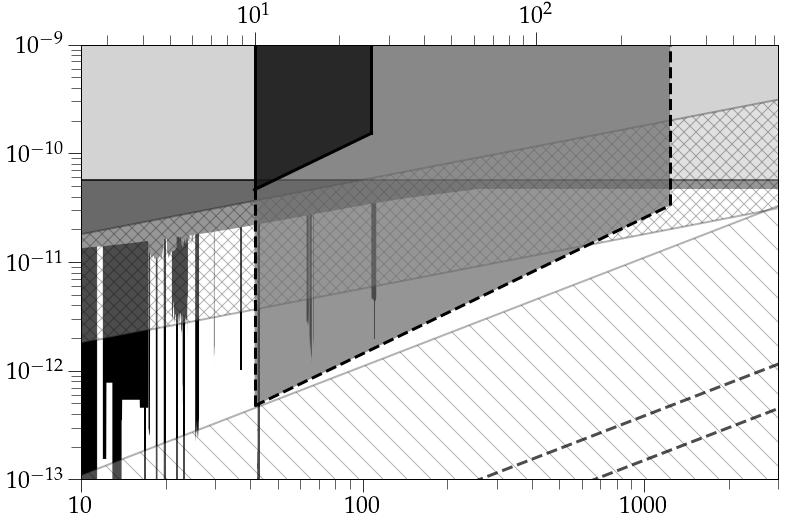

In [81]:
xlim = [1e-5, 3e-3]
fig, ax = drawAxionLimit(text_on=False, drawQCDAxion=False, drawBlackHole=False, 
                         figsize=(12.5, 8), fontsize=24, labelfontsize=30, 
                         xlim=xlim, ylim=[1e-13, 1e-9], frequency_axis=True, xtick_rotation=0,
                         xlabel='', ylabel='', xlabel_top='', lw=0,
                         cosmic_color='dimgray', helioscope_color='lightgray', haloscope_color='black',
                         drawStellarBounds=True, drawSolarBasin=True, drawStAB=True, drawHaloscopes=True, 
                         drawHelioscopes=True, drawLSW=True, drawLowMassAstroBounds=True, drawALPdecay=True,
                         drawNeutronStars=True, drawAxionStarExplosions=True, drawDarkMatterDecay=True,
                         zorderHaloscope=-100,
                        )

# Theory
_x = np.power(10, np.linspace(-6, 0, 61))
# QCD axion
#ax.plot( _x, g_agg_max(_x), ls=':', lw=3, label='E/N=44/3', c='orange')
ax.plot( _x, g_agg_KSVZ(_x), ls='--', lw=3, label='KSVZ', c='k')
ax.plot( _x, g_agg_DFSZI(_x), ls='--', lw=3, label='DFSZI', c='k')
#ax.plot( _x, g_agg_DFSZII(_x), ls=':', lw=3, label='DFSZII', c='orange')
#ax.plot( _x, g_agg_max2(_x), ls=':', lw=5, label='E/N=170/3', c='orange')
ax.fill_between(_x, np.full(len(_x), 0.), g_agg_max2(_x), color='white', edgecolor='k', alpha=0.3, zorder=200, lw=2, ls='-', hatch='\\')
# ALP cogenesis
_ALP1 = 1.8e-11*np.sqrt(_x*1e+3)
_ALP2 = 1.8e-10*np.sqrt(_x*1e+3)
ax.fill_between(_x, _ALP1, _ALP2, color='white', edgecolor='k', alpha=0.3, zorder=100, lw=2, ls='-', hatch='xx')


# Add my limits
#  label=f'9T split coil, 10K, 1 day'
add_limit( ax, _freq1, g(nu=_freq1, B=9, A=0.03*0.05, Tsys=10, t=3600*24*1), 
          color='k', lcolor='k', alpha=0.7, xscale=1., zorder=1000, lw=3, lw_side=3, ls='-', ls_side='-')
# label=f'NIFS 13T, 0.5m$^2$, 4K, 30day'
add_limit( ax, _freq2, g(nu=_freq2, B=13, A=0.5, Tsys=4, t=3600*24*30), 
          color='dimgray', lcolor='k', alpha=0.7, xscale=1., zorder=300, lw=3, lw_side=3, ls='--', ls_side='--')


import matplotlib.ticker as ticker
yticks = ax.get_yticks()
xticks = ax.get_xticks()
xlabels = [ f'{_x:g}' for _x in xticks*1.e+6 ]
#xlabels = [ f'$10^{int(np.log10(_x))}$' for _x in xticks*1.e+6 ]
print(xlabels)
ax.set_xticks(xticks, labels=xlabels)
#ax.set_xlabel('$m_a$ [$\mu$eV]')

#from matplotlib.ticker import ScalarFormatter
#ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
#ax.ticklabel_format(style="sci",  axis="x",scilimits=(0,0))
#ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
#ax.set_xticks(xticks, xticks*1e+6, fontsize=30, rotation=0)
#ax.set_yticklabels(yticks, fontsize=30)
#ax.xaxis.set_major_formatter('{x}')

ax.set_xlim(xlim)

## Without Expectation Black & White

['$10^0$', '$10^1$', '$10^2$', '$10^3$', '$10^4$', '$10^5$']


(1e-05, 0.003)

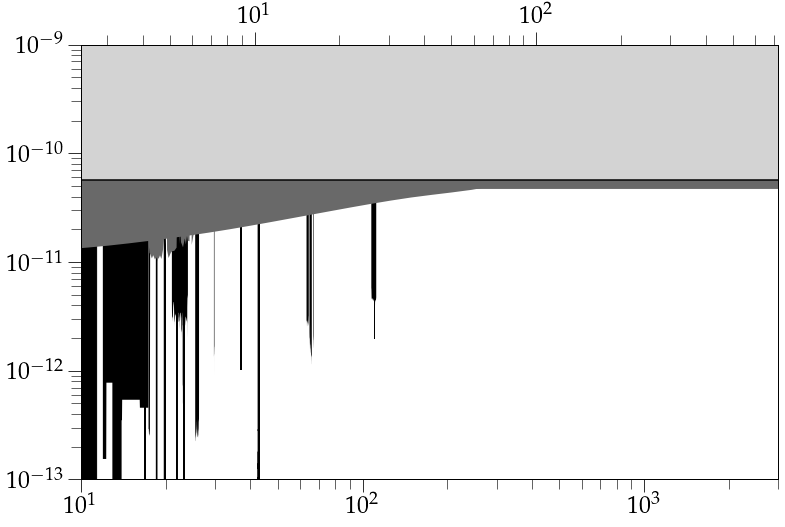

In [82]:
fig, ax = drawAxionLimit(text_on=False, drawQCDAxion=False, drawBlackHole=False, 
                         figsize=(12.5, 8), fontsize=24, labelfontsize=30, 
                         xlim=xlim, ylim=[1e-13, 1e-9], frequency_axis=True, xtick_rotation=0,
                         xlabel='', ylabel='', xlabel_top='', lw=0,
                         cosmic_color='dimgray', helioscope_color='lightgray', haloscope_color='black',
                         drawStellarBounds=True, drawSolarBasin=True, drawStAB=True, drawHaloscopes=True, 
                         drawHelioscopes=True, drawLSW=True, drawLowMassAstroBounds=True, drawALPdecay=True,
                         drawNeutronStars=True, drawAxionStarExplosions=True, drawDarkMatterDecay=True,
                         zorderHaloscope=-100,
                        )

'''
# Theory
_x = np.power(10, np.linspace(-6, 0, 61))
# QCD axion
#ax.plot( _x, g_agg_max(_x), ls=':', lw=3, label='E/N=44/3', c='orange')
ax.plot( _x, g_agg_KSVZ(_x), ls='--', lw=3, label='KSVZ', c='k')
ax.plot( _x, g_agg_DFSZI(_x), ls='--', lw=3, label='DFSZI', c='k')
#ax.plot( _x, g_agg_DFSZII(_x), ls=':', lw=3, label='DFSZII', c='orange')
#ax.plot( _x, g_agg_max2(_x), ls=':', lw=5, label='E/N=170/3', c='orange')
ax.fill_between(_x, np.full(len(_x), 0.), g_agg_max2(_x), color='white', edgecolor='k', alpha=0.3, zorder=200, lw=2, ls='-', hatch='\\')
# ALP cogenesis
_ALP1 = 1.8e-11*np.sqrt(_x*1e+3)
_ALP2 = 1.8e-10*np.sqrt(_x*1e+3)
ax.fill_between(_x, _ALP1, _ALP2, color='white', edgecolor='k', alpha=0.3, zorder=100, lw=2, ls='-', hatch='xx')
'''


yticks = ax.get_yticks()
xticks = ax.get_xticks()
#xlabels = [ f'{_x:g}' for _x in xticks*1.e+6 ]
xlabels = [ f'$10^{int(np.log10(_x))}$' for _x in xticks*1.e+6 ]

print(xlabels)
ax.set_xticks(xticks, labels=xlabels)
ax.set_xlim(xlim)
#ax.set_xlabel('$m_a$ [$\mu$eV]')

## Without Expectation Color

['$10^0$', '$10^1$', '$10^2$', '$10^3$', '$10^4$', '$10^5$', '$10^6$']


(1e-05, 0.01)

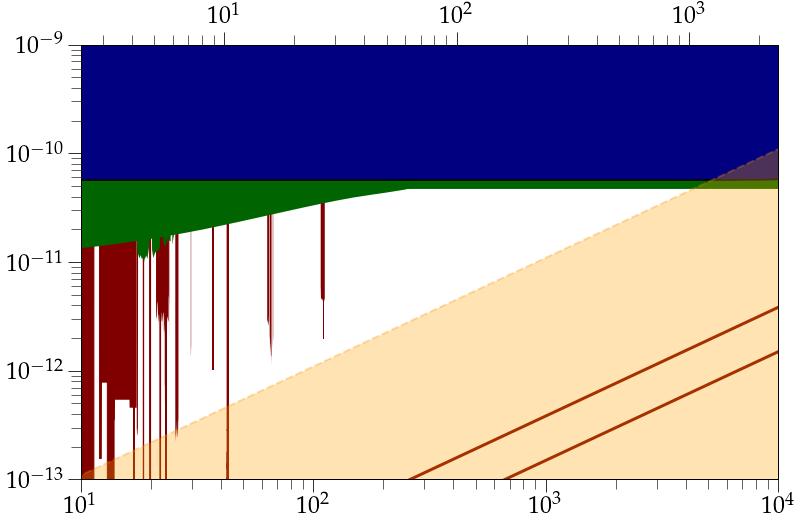

In [83]:
xlim = [1e-5, 1e-2]
fig, ax = drawAxionLimit(text_on=False, drawQCDAxion=False, drawBlackHole=False, 
                         figsize=(12.5, 8), fontsize=24, labelfontsize=30, 
                         xlim=xlim, ylim=[1e-13, 1e-9], frequency_axis=True, xtick_rotation=0,
                         xlabel='', ylabel='', xlabel_top='', lw=0,
                         cosmic_color='darkgreen', helioscope_color='navy', haloscope_color='maroon',
                         drawStellarBounds=True, drawSolarBasin=True, drawStAB=True, drawHaloscopes=True, 
                         drawHelioscopes=True, drawLSW=True, drawLowMassAstroBounds=True, drawALPdecay=True,
                         drawNeutronStars=True, drawAxionStarExplosions=True, drawDarkMatterDecay=True,
                         zorderHaloscope=-100,
                        )

# Theory
_x = np.power(10, np.linspace(-6, 0, 61))
# QCD axion
#ax.plot( _x, g_agg_max(_x), ls=':', lw=3, label='E/N=44/3', c='orange')
ax.plot( _x, g_agg_KSVZ(_x), ls='-', lw=3, label='KSVZ', c='maroon')
ax.plot( _x, g_agg_DFSZI(_x), ls='-', lw=3, label='DFSZI', c='maroon')
#ax.plot( _x, g_agg_DFSZII(_x), ls=':', lw=3, label='DFSZII', c='orange')
#ax.plot( _x, g_agg_max2(_x), ls=':', lw=5, label='E/N=170/3', c='orange')
ax.fill_between(_x, np.full(len(_x), 0.), g_agg_max2(_x), color='orange', edgecolor='darkorange', alpha=0.3, zorder=200, lw=2, ls='--', hatch='')
# ALP cogenesis
#_ALP1 = 1.8e-11*np.sqrt(_x*1e+3)
#_ALP2 = 1.8e-10*np.sqrt(_x*1e+3)
#ax.fill_between(_x, _ALP1, _ALP2, color='orange', edgecolor='darkorange', alpha=0.3, zorder=100, lw=2, ls='--', hatch='')

import matplotlib.ticker as ticker
yticks = ax.get_yticks()
xticks = ax.get_xticks()
#xlabels = [ f'{_x:g}' for _x in xticks*1.e+6 ]
xlabels = [ f'$10^{int(np.log10(_x))}$' for _x in xticks*1.e+6 ]
print(xlabels)
ax.set_xticks(xticks, labels=xlabels)
#ax.set_xlabel('$m_a$ [$\mu$eV]')

ax.set_xlim(xlim)

## With Expectation Color

['1', '10', '100', '1000', '10000', '100000']


(1e-05, 0.003)

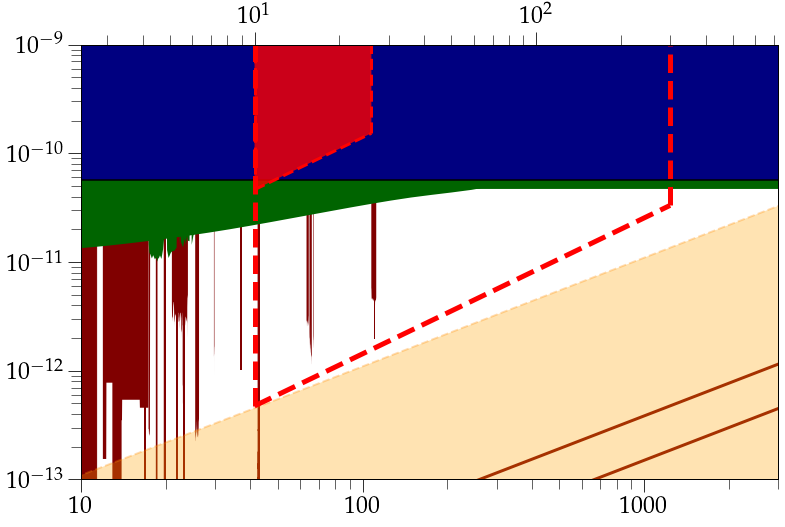

In [84]:
xlim = [1e-5, 3e-3]
fig, ax = drawAxionLimit(text_on=False, drawQCDAxion=False, drawBlackHole=False, 
                         figsize=(12.5, 8), fontsize=24, labelfontsize=30, 
                         xlim=xlim, ylim=[1e-13, 1e-9], frequency_axis=True, xtick_rotation=0,
                         xlabel='', ylabel='', xlabel_top='', lw=0,
                         cosmic_color='darkgreen', helioscope_color='navy', haloscope_color='maroon',
                         drawStellarBounds=True, drawSolarBasin=True, drawStAB=True, drawHaloscopes=True, 
                         drawHelioscopes=True, drawLSW=True, drawLowMassAstroBounds=True, drawALPdecay=True,
                         drawNeutronStars=True, drawAxionStarExplosions=True, drawDarkMatterDecay=True,
                         zorderHaloscope=-100,
                        )

# Theory
_x = np.power(10, np.linspace(-6, 0, 61))
# QCD axion
#ax.plot( _x, g_agg_max(_x), ls=':', lw=3, label='E/N=44/3', c='orange')
ax.plot( _x, g_agg_KSVZ(_x), ls='-', lw=3, label='KSVZ', c='maroon')
ax.plot( _x, g_agg_DFSZI(_x), ls='-', lw=3, label='DFSZI', c='maroon')
#ax.plot( _x, g_agg_DFSZII(_x), ls=':', lw=3, label='DFSZII', c='orange')
#ax.plot( _x, g_agg_max2(_x), ls=':', lw=5, label='E/N=170/3', c='orange')
ax.fill_between(_x, np.full(len(_x), 0.), g_agg_max2(_x), color='orange', edgecolor='darkorange', alpha=0.3, zorder=200, lw=2, ls='--', hatch='')
# ALP cogenesis
_ALP1 = 1.8e-11*np.sqrt(_x*1e+3)
_ALP2 = 1.8e-10*np.sqrt(_x*1e+3)
#ax.fill_between(_x, _ALP1, _ALP2, color='orange', edgecolor='darkorange', alpha=0.3, zorder=100, lw=2, ls='--', hatch='')


# Add my limits
#  label=f'9T split coil, 10K, 1 day'
add_limit( ax, _freq1, g(nu=_freq1, B=9, A=0.03*0.05, Tsys=10, t=3600*24*1), 
          #color='red', lcolor='r', alpha=0.7, xscale=1., zorder=1000, lw=3, lw_side=3, ls='--', ls_side='--')
          color='red', lcolor='r', alpha=0.8, xscale=1., zorder=1000, lw=3, lw_side=3, ls='--', ls_side='--')
# label=f'NIFS 13T, 0.5m$^2$, 4K, 30day'
add_limit( ax, _freq2, g(nu=_freq2, B=13, A=0.5, Tsys=4, t=3600*24*30), 
          color='red', lcolor='r', alpha=0., xscale=1., zorder=300, lw=5, lw_side=5, ls='--', ls_side='--')

import matplotlib.ticker as ticker
yticks = ax.get_yticks()
xticks = ax.get_xticks()
xlabels = [ f'{_x:g}' for _x in xticks*1.e+6 ]
#xlabels = [ f'$10^{int(np.log10(_x))}$' for _x in xticks*1.e+6 ]
print(xlabels)
ax.set_xticks(xticks, labels=xlabels)
#ax.set_xlabel('$m_a$ [$\mu$eV]')

#from matplotlib.ticker import ScalarFormatter
#ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
#ax.ticklabel_format(style="sci",  axis="x",scilimits=(0,0))
#ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
#ax.set_xticks(xticks, xticks*1e+6, fontsize=30, rotation=0)
#ax.set_yticklabels(yticks, fontsize=30)
#ax.xaxis.set_major_formatter('{x}')

ax.set_xlim(xlim)

## With First Experiment Expectation / No theory : Color

['1', '10', '100', '1000', '10000', '100000']


(1e-05, 0.003)

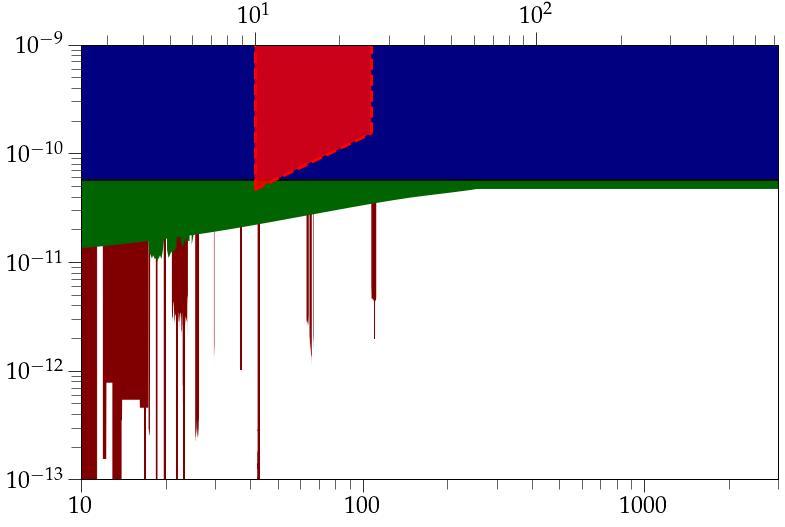

In [85]:
xlim = [1e-5, 3e-3]
fig, ax = drawAxionLimit(text_on=False, drawQCDAxion=False, drawBlackHole=False, 
                         figsize=(12.5, 8), fontsize=24, labelfontsize=30, 
                         xlim=xlim, ylim=[1e-13, 1e-9], frequency_axis=True, xtick_rotation=0,
                         xlabel='', ylabel='', xlabel_top='', lw=0,
                         cosmic_color='darkgreen', helioscope_color='navy', haloscope_color='maroon',
                         drawStellarBounds=True, drawSolarBasin=True, drawStAB=True, drawHaloscopes=True, 
                         drawHelioscopes=True, drawLSW=True, drawLowMassAstroBounds=True, drawALPdecay=True,
                         drawNeutronStars=True, drawAxionStarExplosions=True, drawDarkMatterDecay=True,
                         zorderHaloscope=-100,
                        )

# Theory
_x = np.power(10, np.linspace(-6, 0, 61))
# QCD axion
#ax.plot( _x, g_agg_max(_x), ls=':', lw=3, label='E/N=44/3', c='orange')
#ax.plot( _x, g_agg_KSVZ(_x), ls='-', lw=3, label='KSVZ', c='maroon')
#ax.plot( _x, g_agg_DFSZI(_x), ls='-', lw=3, label='DFSZI', c='maroon')
#ax.plot( _x, g_agg_DFSZII(_x), ls=':', lw=3, label='DFSZII', c='orange')
#ax.plot( _x, g_agg_max2(_x), ls=':', lw=5, label='E/N=170/3', c='orange')
#ax.fill_between(_x, np.full(len(_x), 0.), g_agg_max2(_x), color='orange', edgecolor='darkorange', alpha=0.3, zorder=200, lw=2, ls='--', hatch='')
# ALP cogenesis
_ALP1 = 1.8e-11*np.sqrt(_x*1e+3)
_ALP2 = 1.8e-10*np.sqrt(_x*1e+3)
#ax.fill_between(_x, _ALP1, _ALP2, color='orange', edgecolor='darkorange', alpha=0.3, zorder=100, lw=2, ls='--', hatch='')


# Add my limits
#  label=f'9T split coil, 10K, 1 day'
add_limit( ax, _freq1, g(nu=_freq1, B=9, A=0.03*0.05, Tsys=10, t=3600*24*1), 
          #color='red', lcolor='r', alpha=0.7, xscale=1., zorder=1000, lw=3, lw_side=3, ls='--', ls_side='--')
          color='red', lcolor='r', alpha=0.8, xscale=1., zorder=1000, lw=3, lw_side=3, ls='--', ls_side='--')
# label=f'NIFS 13T, 0.5m$^2$, 4K, 30day'
#add_limit( ax, _freq2, g(nu=_freq2, B=13, A=0.5, Tsys=4, t=3600*24*30), 
#          color='red', lcolor='r', alpha=0., xscale=1., zorder=300, lw=5, lw_side=5, ls='--', ls_side='--')


import matplotlib.ticker as ticker
yticks = ax.get_yticks()
xticks = ax.get_xticks()
xlabels = [ f'{_x:g}' for _x in xticks*1.e+6 ]
#xlabels = [ f'$10^{int(np.log10(_x))}$' for _x in xticks*1.e+6 ]
print(xlabels)
ax.set_xticks(xticks, labels=xlabels)
#ax.set_xlabel('$m_a$ [$\mu$eV]')

#from matplotlib.ticker import ScalarFormatter
#ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
#ax.ticklabel_format(style="sci",  axis="x",scilimits=(0,0))
#ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
#ax.set_xticks(xticks, xticks*1e+6, fontsize=30, rotation=0)
#ax.set_yticklabels(yticks, fontsize=30)
#ax.xaxis.set_major_formatter('{x}')

ax.set_xlim(xlim)

## Without Expectation / No theory: Color

['$10^0$', '$10^1$', '$10^2$', '$10^3$', '$10^4$', '$10^5$']


(1e-05, 0.003)

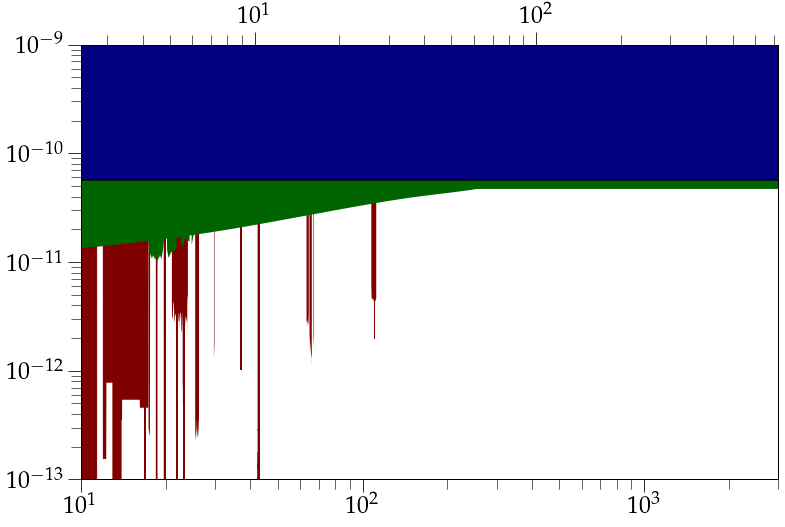

In [86]:
fig, ax = drawAxionLimit(text_on=False, drawQCDAxion=False, drawBlackHole=False, 
                         figsize=(12.5, 8), fontsize=24, labelfontsize=30, 
                         xlim=xlim, ylim=[1e-13, 1e-9], frequency_axis=True, xtick_rotation=0,
                         xlabel='', ylabel='', xlabel_top='', lw=0,
                         cosmic_color='darkgreen', helioscope_color='navy', haloscope_color='maroon',
                         drawStellarBounds=True, drawSolarBasin=True, drawStAB=True, drawHaloscopes=True, 
                         drawHelioscopes=True, drawLSW=True, drawLowMassAstroBounds=True, drawALPdecay=True,
                         drawNeutronStars=True, drawAxionStarExplosions=True, drawDarkMatterDecay=True,
                         zorderHaloscope=-100,
                        )

'''
# Theory
_x = np.power(10, np.linspace(-6, 0, 61))
# QCD axion
#ax.plot( _x, g_agg_max(_x), ls=':', lw=3, label='E/N=44/3', c='orange')
ax.plot( _x, g_agg_KSVZ(_x), ls='--', lw=3, label='KSVZ', c='k')
ax.plot( _x, g_agg_DFSZI(_x), ls='--', lw=3, label='DFSZI', c='k')
#ax.plot( _x, g_agg_DFSZII(_x), ls=':', lw=3, label='DFSZII', c='orange')
#ax.plot( _x, g_agg_max2(_x), ls=':', lw=5, label='E/N=170/3', c='orange')
ax.fill_between(_x, np.full(len(_x), 0.), g_agg_max2(_x), color='white', edgecolor='k', alpha=0.3, zorder=200, lw=2, ls='-', hatch='\\')
# ALP cogenesis
_ALP1 = 1.8e-11*np.sqrt(_x*1e+3)
_ALP2 = 1.8e-10*np.sqrt(_x*1e+3)
ax.fill_between(_x, _ALP1, _ALP2, color='white', edgecolor='k', alpha=0.3, zorder=100, lw=2, ls='-', hatch='xx')
'''


yticks = ax.get_yticks()
xticks = ax.get_xticks()
#xlabels = [ f'{_x:g}' for _x in xticks*1.e+6 ]
xlabels = [ f'$10^{int(np.log10(_x))}$' for _x in xticks*1.e+6 ]

print(xlabels)
ax.set_xticks(xticks, labels=xlabels)
ax.set_xlim(xlim)
#ax.set_xlabel('$m_a$ [$\mu$eV]')

# Limit: AxionLimits from 20250816
## Import AxionLimits

In [53]:
axionLimitDir='20250816_for_adachi'

In [54]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from numpy import *
import matplotlib.pyplot as plt
import os
import sys
cwd=os.getcwd()
axionLimitPath=cwd+'/../../../AxionLimits/'+axionLimitDir

# remove unnecessary path
remove_path_list = []
for _path in sys.path:
    print(_path)
    if _path.startswith(cwd+'/../../../AxionLimits'):
        remove_path_list.append(_path)
        pass
    pass
for _path in remove_path_list:
    sys.path.remove(_path)
    pass
print('path=', sys.path)

# Add axionLimitPath
if not os.path.isdir(axionLimitPath):
    print(f'ERROR!!: No directory! {axionLimitPath}')
    pass
print(axionLimitPath)
if not (axionLimitPath in sys.path):
    sys.path.append(axionLimitPath)
    pass
if os.path.islink('limit_data'):
    print('Unlink limit_data.')
    os.unlink('limit_data')
    pass
os.symlink(axionLimitPath+'/limit_data', 'limit_data')
print('path = ', sys.path)

# Import of PlotFuncs

import importlib

# 確認したいモジュール名
module_name = 'PlotFuncs' # 例としてrequestsモジュール
#  モジュールがインポートされているか確認
if module_name in sys.modules:
    print(f"モジュール '{module_name}' は既にインポートされています。")
    
    # sys.modulesからモジュールを削除
    try:
        del sys.modules[module_name]
    except Exception as e:
        print(f'Error in remove module: {module_name}')
    pass
        
# import module
import PlotFuncs
print(f'PlotFuncs path: {PlotFuncs.__file__}')

/data/analysis/adachi/analysis/Limit
/usr/lib/python38.zip
/usr/lib/python3.8
/usr/lib/python3.8/lib-dynload

/home/dosue/venv/env1/lib/python3.8/site-packages
/home/dosue/venv/env1/lib/python3.8/site-packages/IPython/extensions
/home/adachi/.ipython
/data/analysis/adachi/analysis/Limit/../../../AxionLimits/20250816_for_adachi
path= ['/data/analysis/adachi/analysis/Limit', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/home/dosue/venv/env1/lib/python3.8/site-packages', '/home/dosue/venv/env1/lib/python3.8/site-packages/IPython/extensions', '/home/adachi/.ipython']
/data/analysis/adachi/analysis/Limit/../../../AxionLimits/20250816_for_adachi
Unlink limit_data.
path =  ['/data/analysis/adachi/analysis/Limit', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/home/dosue/venv/env1/lib/python3.8/site-packages', '/home/dosue/venv/env1/lib/python3.8/site-packages/IPython/extensions', '/home/adachi/.ipython', '/data/a

## Draw Function

In [55]:
def drawAxionLimit(text_on=True, figsize=(16.5, 11), fontsize=25, labelfontsize=45, xtick_rotation=20, xlim=[1e-12, 1e+7], ylim=[1e-19, 1e-6],
                   frequency_axis=False, N_Hz=1e+9, xlabel=r'$m_a$ [eV]', ylabel=r'$|g_{a\gamma\gamma}|$ [GeV$^{-1}$]', xlabel_top=r'$\nu_a$ [GHz]',
                   lw=None,
                   haloscope_color=None, helioscope_color=None, cosmic_color=None, other_color=None,
                   drawStellarBounds=True, drawSolarBasin=True, drawStAB=True, drawHaloscopes=True, 
                   drawHelioscopes=True, drawLSW=True, drawLowMassAstroBounds=True, drawALPdecay=True,
                   drawNeutronStars=True, drawAxionStarExplosions=True, drawDarkMatterDecay=True,
                   drawQCDAxion=True, drawBlackHole=False, 
                   zorderHaloscope=0, 
                  ):
    fig,ax,ax2 = PlotFuncs.FigSetup(Shape='Custom',xlab=xlabel, ylab=ylabel, upper_xlabel=xlabel_top, FrequencyAxis=frequency_axis, 
                      m_min=xlim[0], m_max=xlim[1], g_min=ylim[0], g_max=ylim[1], xtick_rotation=xtick_rotation, N_Hz=N_Hz,
                        mathpazo=False, figsize=figsize, tfs=fontsize, lfs=labelfontsize)
       
    if drawQCDAxion: PlotFuncs.AxionPhoton.QCDAxion(ax, text_on=text_on)
    if drawStellarBounds: 
        _lw = 1.5 if lw is None else lw
        if cosmic_color is None: PlotFuncs.AxionPhoton.StellarBounds(ax, text_on=text_on, lw=_lw)
        else: PlotFuncs.AxionPhoton.StellarBounds(ax, text_on=text_on, col=cosmic_color, lw=_lw)
        pass
    if cosmic_color is None:
        if drawSolarBasin: 
            if lw is None: PlotFuncs.AxionPhoton.SolarBasin(ax, text_on=text_on)
            else: PlotFuncs.AxionPhoton.SolarBasin(ax, text_on=text_on, lw=lw)
        if drawStAB: 
            if lw is None: PlotFuncs.AxionPhoton.StAB(ax, text_on=text_on)
            else: PlotFuncs.AxionPhoton.StAB(ax, text_on=text_on, lw=lw)
    else:
        if drawSolarBasin: 
            if lw is None: PlotFuncs.AxionPhoton.SolarBasin(ax, text_on=text_on, col=cosmic_color)
            else: PlotFuncs.AxionPhoton.SolarBasin(ax, text_on=text_on, col=cosmic_color, lw=lw)
        if drawStAB: 
            if lw is None: PlotFuncs.AxionPhoton.StAB(ax, text_on=text_on, col=cosmic_color)
            else: PlotFuncs.AxionPhoton.StAB(ax, text_on=text_on, col=cosmic_color, lw=lw)
        pass
    
    if haloscope_color is None:
        if drawHaloscopes: PlotFuncs.AxionPhoton.Haloscopes(ax,BASE_arrow_on=False, text_on=text_on, zorder=zorderHaloscope)
    else:
        if drawHaloscopes: PlotFuncs.AxionPhoton.Haloscopes(ax,BASE_arrow_on=False, text_on=text_on, col=haloscope_color, zorder=zorderHaloscope)
        pass
    if helioscope_color is None:
        if drawHelioscopes: PlotFuncs.AxionPhoton.Helioscopes(ax, text_on=text_on)
    else:
        if drawHelioscopes: PlotFuncs.AxionPhoton.Helioscopes(ax, text_on=text_on, col=helioscope_color)
        pass
    if drawLSW: PlotFuncs.AxionPhoton.LSW(ax, text_on=text_on)
    
    if drawLowMassAstroBounds: 
        if cosmic_color is None: PlotFuncs.AxionPhoton.LowMassAstroBounds(ax, text_on=text_on, lw=lw)
        else: PlotFuncs.AxionPhoton.LowMassAstroBounds(ax, text_on=text_on, lw=lw, col=cosmic_color)
        pass
    if drawALPdecay: PlotFuncs.AxionPhoton.ALPdecay(ax, text_on=text_on)
    if cosmic_color is None:
        if drawNeutronStars:    
            if lw is None: PlotFuncs.AxionPhoton.NeutronStars(ax, text_on=text_on)
            else: PlotFuncs.AxionPhoton.NeutronStars(ax, text_on=text_on, lw=lw)
            pass
        if drawAxionStarExplosions:  
            if lw is None: PlotFuncs.AxionPhoton.AxionStarExplosions(ax, text_on=text_on)
            else: PlotFuncs.AxionPhoton.AxionStarExplosions(ax, text_on=text_on, lw=lw)
            pass
        if drawDarkMatterDecay: PlotFuncs.AxionPhoton.DarkMatterDecay(ax, text_on=text_on)
        if drawBlackHole: PlotFuncs.BlackHoleSpins(ax,(1/137)*(1/(2*pi)),[1.5e-12,0.5e-17],rotation=-90,alpha=1,fs=18,facecolor=[0.7,0.7,0.7],whichfile='Baryakhtar')
    else:
        if drawNeutronStars:    
            if lw is None: PlotFuncs.AxionPhoton.NeutronStars(ax, text_on=text_on, col=cosmic_color)
            else: PlotFuncs.AxionPhoton.NeutronStars(ax, text_on=text_on, col=cosmic_color, lw=lw)
            pass
        if drawAxionStarExplosions:  
            if lw is None: PlotFuncs.AxionPhoton.AxionStarExplosions(ax, text_on=text_on, col=cosmic_color)
            else: PlotFuncs.AxionPhoton.AxionStarExplosions(ax, text_on=text_on, col=cosmic_color, lw=lw)
            pass
        if drawDarkMatterDecay: PlotFuncs.AxionPhoton.DarkMatterDecay(ax, text_on=text_on, col=cosmic_color)
        if drawBlackHole: PlotFuncs.BlackHoleSpins(ax,(1/137)*(1/(2*pi)),[1.5e-12,0.5e-17],rotation=-90,alpha=1,fs=18,facecolor=cosmic_color,whichfile='Baryakhtar')
        pass
    
    import matplotlib.ticker as ticker
    xlim = ax.get_xlim()
    xlim2 = ax2.get_xlim()
    ylim = ax.get_ylim()
    
    # Set x bottom ticks
    xticks = ax.get_xticks()
    print(f'xticks = {xticks}')
    xlabels = [ '$10^{'+f'{int(np.log10(_x))}'+'}$' if _x!=1 else '$1$' for _x in xticks*1e+6]
    print(f'xlabels = {xlabels}')
    ax.set_xticks(xticks, labels=xlabels, fontsize=fontsize)
    
    # Set x top ticks
    xticks2 = ax2.get_xticks()
    print(f'xticks(top) = {xticks}')
    xlabels2 = [ f'${int(_x)}' + ' \\rm{GHz}$' if _x<1000 else f'${int(_x/1000)}' + ' \\rm{THz}$' for _x in xticks2 ]
    print(f'xlabels(top) = {xlabels2}')
    ax2.set_xticks(xticks2, labels=xlabels2, fontsize=fontsize)
    
    # Set y ticks
    yticks = ax.get_yticks()
    print(f'yticks = {yticks}')
    ylabels = [ '$10^{'+f'{int(np.log10(_y))}'+'}$' if _y!=1 else '$1$' for _y in yticks]
    print(f'ylabels = {ylabels}')
    ax.set_yticks(yticks, labels=ylabels, fontsize=fontsize)
    
    # Set x lim
    ax.set_xlim(xlim)
    ax2.set_xlim(xlim2)
    ax.set_ylim(ylim)
    
    # Set font
    plt.rcParams["mathtext.fontset"] = 'dejavusans'
    plt.rcParams["font.family"] = 'sans'
    
    return fig, ax, ax2

## Without Expectation Color

xticks = [1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01 1.e+00]
xlabels = ['$10^{-1}$', '$1$', '$10^{1}$', '$10^{2}$', '$10^{3}$', '$10^{4}$', '$10^{5}$', '$10^{6}$']
xticks(top) = [1.e-07 1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01 1.e+00]
xlabels(top) = ['$0 \\rm{GHz}$', '$0 \\rm{GHz}$', '$1 \\rm{GHz}$', '$10 \\rm{GHz}$', '$100 \\rm{GHz}$', '$1 \\rm{THz}$', '$10 \\rm{THz}$', '$100 \\rm{THz}$', '$1000 \\rm{THz}$']
yticks = [1.e-15 1.e-14 1.e-13 1.e-12 1.e-11 1.e-10 1.e-09 1.e-08 1.e-07]
ylabels = ['$10^{-15}$', '$10^{-14}$', '$10^{-13}$', '$10^{-12}$', '$10^{-11}$', '$10^{-10}$', '$10^{-9}$', '$10^{-8}$', '$10^{-7}$']


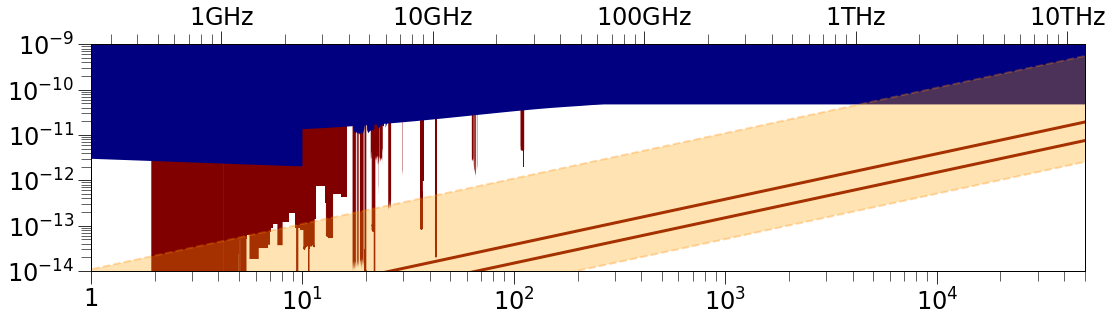

In [58]:
xlim = [1e-6, 5e-2]
fig, ax, ax2 = drawAxionLimit(text_on=False, drawQCDAxion=False, drawBlackHole=False, 
                         figsize=(16, 5), fontsize=24, labelfontsize=30, 
                         xlim=xlim, ylim=[1e-14, 1e-9], frequency_axis=True, xtick_rotation=0,
                         xlabel='', ylabel='', xlabel_top='', lw=0,
                         #cosmic_color='darkgreen', helioscope_color='navy', haloscope_color='maroon',
                         cosmic_color='navy', helioscope_color='navy', haloscope_color='maroon',
                         drawStellarBounds=True, drawSolarBasin=True, drawStAB=True, drawHaloscopes=True, 
                         #drawHelioscopes=True, drawLSW=True, drawLowMassAstroBounds=True, drawALPdecay=True,
                         drawHelioscopes=False, drawLSW=True, drawLowMassAstroBounds=True, drawALPdecay=True,
                         drawNeutronStars=True, drawAxionStarExplosions=True, drawDarkMatterDecay=True,
                         zorderHaloscope=-100,
                        )

# Theory
_x = np.power(10, np.linspace(-6, 0, 61))
# QCD axion
#ax.plot( _x, g_agg_max(_x), ls=':', lw=3, label='E/N=44/3', c='orange')
ax.plot( _x, g_agg_KSVZ(_x), ls='-', lw=3, label='KSVZ', c='maroon')
ax.plot( _x, g_agg_DFSZI(_x), ls='-', lw=3, label='DFSZI', c='maroon')
#ax.plot( _x, g_agg_DFSZII(_x), ls=':', lw=3, label='DFSZII', c='orange')
#ax.plot( _x, g_agg_max2(_x), ls=':', lw=5, label='E/N=170/3', c='orange')
#ax.fill_between(_x, np.full(len(_x), 0.), g_agg_max2(_x), color='orange', edgecolor='darkorange', alpha=0.3, zorder=200, lw=2, ls='--', hatch='')
ax.fill_between(_x, g_agg_min(_x), g_agg_max2(_x), color='orange', edgecolor='darkorange', alpha=0.3, zorder=200, lw=2, ls='--', hatch='')
#print(g_agg_min(1e-6))
# ALP cogenesis
#_ALP1 = 1.8e-11*np.sqrt(_x*1e+3)
#_ALP2 = 1.8e-10*np.sqrt(_x*1e+3)
#ax.fill_between(_x, _ALP1, _ALP2, color='orange', edgecolor='darkorange', alpha=0.3, zorder=100, lw=2, ls='--', hatch='')
fig.tight_layout()

## With New Expectation Color using PA

xticks = [1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]
xlabels = ['$1$', '$10^{1}$', '$10^{2}$', '$10^{3}$', '$10^{4}$', '$10^{5}$']
xticks(top) = [1.e-06 1.e-05 1.e-04 1.e-03 1.e-02 1.e-01]
xlabels(top) = ['$0 \\rm{GHz}$', '$1 \\rm{GHz}$', '$10 \\rm{GHz}$', '$100 \\rm{GHz}$', '$1 \\rm{THz}$', '$10 \\rm{THz}$']
yticks = [1.e-14 1.e-13 1.e-12 1.e-11 1.e-10 1.e-09 1.e-08 1.e-07]
ylabels = ['$10^{-14}$', '$10^{-13}$', '$10^{-12}$', '$10^{-11}$', '$10^{-10}$', '$10^{-9}$', '$10^{-8}$', '$10^{-7}$']
['1', '10', '100', '1000', '10000', '100000']


(1e-05, 0.003)

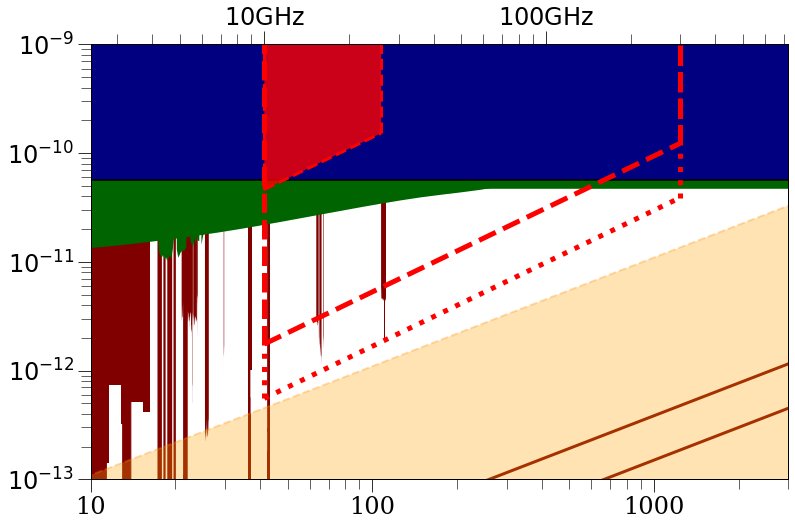

In [46]:
xlim = [1e-5, 3e-3]
fig, ax, ax2 = drawAxionLimit(text_on=False, drawQCDAxion=False, drawBlackHole=False, 
                         figsize=(12.5, 8), fontsize=24, labelfontsize=30, 
                         xlim=xlim, ylim=[1e-13, 1e-9], frequency_axis=True, xtick_rotation=0,
                         xlabel='', ylabel='', xlabel_top='', lw=0,
                         cosmic_color='darkgreen', helioscope_color='navy', haloscope_color='maroon',
                         drawStellarBounds=True, drawSolarBasin=True, drawStAB=True, drawHaloscopes=True, 
                         drawHelioscopes=True, drawLSW=True, drawLowMassAstroBounds=True, drawALPdecay=True,
                         drawNeutronStars=True, drawAxionStarExplosions=True, drawDarkMatterDecay=True,
                         zorderHaloscope=-100,
                        )

# Theory
_x = np.power(10, np.linspace(-6, 0, 61))
# QCD axion
#ax.plot( _x, g_agg_max(_x), ls=':', lw=3, label='E/N=44/3', c='orange')
ax.plot( _x, g_agg_KSVZ(_x), ls='-', lw=3, label='KSVZ', c='maroon')
ax.plot( _x, g_agg_DFSZI(_x), ls='-', lw=3, label='DFSZI', c='maroon')
#ax.plot( _x, g_agg_DFSZII(_x), ls=':', lw=3, label='DFSZII', c='orange')
#ax.plot( _x, g_agg_max2(_x), ls=':', lw=5, label='E/N=170/3', c='orange')
ax.fill_between(_x, np.full(len(_x), 0.), g_agg_max2(_x), color='orange', edgecolor='darkorange', alpha=0.3, zorder=200, lw=2, ls='--', hatch='')
# ALP cogenesis
_ALP1 = 1.8e-11*np.sqrt(_x*1e+3)
_ALP2 = 1.8e-10*np.sqrt(_x*1e+3)
#ax.fill_between(_x, _ALP1, _ALP2, color='orange', edgecolor='darkorange', alpha=0.3, zorder=100, lw=2, ls='--', hatch='')


# Add my limits
#  label=f'9T split coil, 10K, 1 day'
add_limit( ax, _freq1, g(nu=_freq1, B=9, A=0.03*0.05, Tsys=10, t=3600*24*1), 
          #color='red', lcolor='r', alpha=0.7, xscale=1., zorder=1000, lw=3, lw_side=3, ls='--', ls_side='--')
          color='red', lcolor='r', alpha=0.8, xscale=1., zorder=1000, lw=3, lw_side=3, ls='--', ls_side='--')
# label=f'NIFS 13T, 0.5m$^2$, 10K, 1day'
add_limit( ax, _freq2, g(nu=_freq2, B=13, A=0.5, Tsys=10, t=3600*24*1), 
          color='red', lcolor='r', alpha=0., xscale=1., zorder=300, lw=5, lw_side=5, ls='--', ls_side='--')
# label=f'NIFS 13T, 0.5m$^2$, 1K, 1day'
add_limit( ax, _freq2, g(nu=_freq2, B=13, A=0.5, Tsys=1, t=3600*24*1), 
          color='red', lcolor='r', alpha=0., xscale=1., zorder=300, lw=5, lw_side=5, ls=':', ls_side=':')

import matplotlib.ticker as ticker
yticks = ax.get_yticks()
xticks = ax.get_xticks()
xlabels = [ f'{_x:g}' for _x in xticks*1.e+6 ]
#xlabels = [ f'$10^{int(np.log10(_x))}$' for _x in xticks*1.e+6 ]
print(xlabels)
ax.set_xticks(xticks, labels=xlabels)
#ax.set_xlabel('$m_a$ [$\mu$eV]')

#from matplotlib.ticker import ScalarFormatter
#ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
#ax.ticklabel_format(style="sci",  axis="x",scilimits=(0,0))
#ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
#ax.set_xticks(xticks, xticks*1e+6, fontsize=30, rotation=0)
#ax.set_yticklabels(yticks, fontsize=30)
#ax.xaxis.set_major_formatter('{x}')

ax.set_xlim(xlim)